<a id="top"></a>

# Finding M dwarf flares with TESS

***

# Learning goals
By the end of this tutorial, you will:
- Be able to identify M dwarf flares in TESS data.
- Understand what a periodogram is.
- Construct periodograms for high-cadence TESS light curves.
- Understand how to mask and process light curve data.
- Extract light curve time stamps corresponding to flares.

# Introduction
The flare rate of M dwarfs — the lowest-mass stars that undergo nuclear fusion — has a broad class of science cases. Flare rates have ramifications for stellar physics (e.g., connections to stellar mass and rotation period; e.g., [Kiraga et al. 2007](https://arxiv.org/abs/0707.2577), [Stelzer et al. 2016](https://academic.oup.com/mnras/article/463/2/1844/2892103)) and exoplanet science (e.g., photochemistry and habitability; e.g., [Segura et al. 2010](https://www.liebertpub.com/doi/full/10.1089/ast.2009.0376), [Shields et al. 2016](https://www.sciencedirect.com/science/article/pii/S0370157316303179?casa_token=eKXCXFI76KkAAAAA:M-W1aEVwaOcGa8dP-PNplduHpgs6gvVpD_YzQSTUNXEi7NpXK-H69ff-JkDElAtSzodIVii3S30)). Time-series MAST data can be used to capture and constrain flares. 

This tutorial continues a series exploring how to use MAST data for such purposes. In this portion, we will find flares in TESS data, following much of the flare-finding procedure from [Günther et al. 2020.](https://iopscience.iop.org/article/10.3847/1538-3881/ab5d3a/meta)

While this tutorial will result in some flare candidates, there are other to robust flare-detection (e.g., detrending with a spline fit, modeling the flare as a function of physical parameters) that are not depicted in this tutorial for the sake of brevity. 


The workflow for this notebook consists of:

- [Overview of flare-detection steps](#Overview-of-flare-detection-steps)
- [Download data](#Download-data)
- [Periodogram analysis](#Periodogram-analysis)
- [Flare candidate detection](#Flare-candidate-detection)
- [Write timestamps](#Write-timestamps)

# Imports
- numpy to help aggregate our metadata.
- matplotlib to plot our data
- sys (Python builtin) to read our machine's Python version.
- astropy to provide data structures that organize our metadata, units functionality, and coordinates functionality.
- lightkurve to download and manipulate our light curve data.

In [227]:
# download the list
import pandas as pd

from astropy.coordinates import position_angle

import matplotlib.pyplot as plt

from urllib.error import HTTPError

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord


import numpy as np
from astropy.timeseries import LombScargle
import astropy.io.fits as fits
from astropy.table import Table, vstack, unique

import lightkurve
from astropy.convolution import Gaussian1DKernel, Box1DKernel, convolve

## Overview of flare-detection steps
- remove strong periodicity with lomb-scargle given some steps, max 3 times.
- iteratively mask out 3 sigma outliers.
- detect flares as at least 6 minutes of flux above 3 sigma threshold.

## Download data

Our first step is to take a look at what `lightkurve` data is available for Proxima Centauri. We will largely follow the procedures from our `downloading_exoplanet_data` and `plot_exoplanet_lightcurves` notebooks; these notebooks demonstrate the various ways to retrieve and visualize MAST exoplanet data [link here].

In [228]:
star = 'Proxima Centauri'

search_result = lightkurve.search_lightcurve(star)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,388857263,0.0
1,TESS Sector 11,2019,TESS-SPOC,1800,388857263,0.0
2,TESS Sector 11,2019,QLP,1800,388857263,0.0
3,TESS Sector 12,2019,SPOC,120,388857263,0.0
4,TESS Sector 12,2019,TESS-SPOC,1800,388857263,0.0
5,TESS Sector 12,2019,QLP,1800,388857263,0.0
6,TESS Sector 38,2021,SPOC,20,388857263,0.0
7,TESS Sector 38,2021,SPOC,120,388857263,0.0
8,TESS Sector 38,2021,SPOC,120,1019422496,0.0


To keep things simple, let's just download and plot the first light curve. We'll also keep track of the exposure time for this set of observations — we'll need this information to identify flares later on.

In [489]:
# for illustration, download the first lightcurve
download_index = 0
lightcurve = search_result[download_index].download()
exposure_time = search_result.exptime[download_index]
lightcurve

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1596.7812314852974,———,———,3.6637241e-03,265912,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.782620410849,———,———,3.6637613e-03,265913,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7840093364,———,———,3.6637986e-03,265914,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.785398261952,———,———,3.6638358e-03,265915,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.786787187271,———,———,3.6638728e-03,265916,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7881761128226,———,———,3.6639101e-03,265917,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7895650383737,———,———,3.6639473e-03,265918,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———
1596.7909539639252,———,———,3.6639846e-03,265919,———,———,———,———,———,———,———,———,10000000010000,———,———,———,———,———,———,———,———,———,———


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

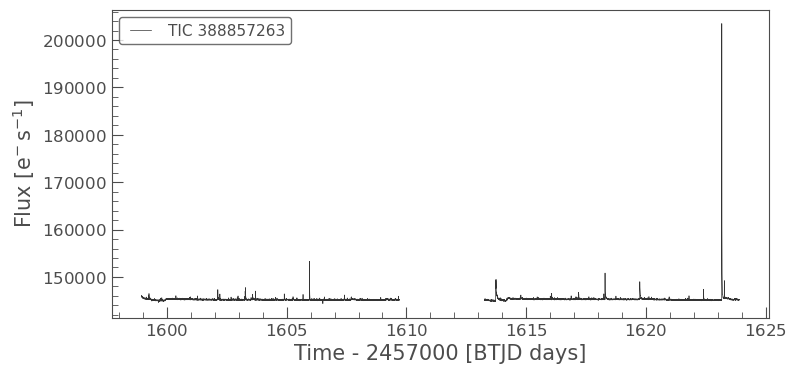

In [490]:
lightcurve.plot()

There's a pretty strong outlier evident; let's remove it and see how the resultant lightcurve looks.

In [491]:
lightcurve = lightcurve.remove_outliers(sigma=10)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

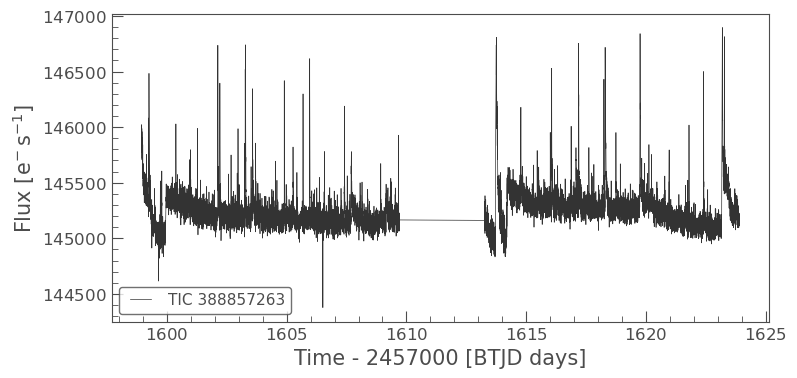

In [492]:
lightcurve.plot()

By eye, we can already tell that the baseline flux for this target exhibits some periodicity. In the next section, we will explore how to remove this periodicity to increase the sensitivity of our flares search.

# Periodogram analysis

Our next steps will involve removing periodic trends in our lightcurve. We can do so by using a Lomb-Scargle periodogram, a statistical tool that can be used to used to identify periodicity in datasets. [Günther et al. 2020.](https://iopscience.iop.org/article/10.3847/1538-3881/ab5d3a/meta) recommend iteratively removing Lomb-Scargle-derived periodicity up to three times for a given lightcurve. Doing so takes into account the idea that stars can have varying sources of variability on different timescales and at different amplitudes (e.g., starspots, stellar pulsation modes).


First, we set up our periodogram object using our `lightkurve`-provided values.

In [493]:
ls = LombScargle(lightcurve.time.value, lightcurve.flux.value, dy=lightcurve.flux_err.value)


We then use the periodogram to derive the sinusoid that best describes the underlying variability in our data.

In [494]:
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [495]:
best_frequency

0.05208019309727815

In [496]:
lightcurve.time.value

array([1598.93407022, 1598.93545914, 1598.93684807, ..., 1623.89279743,
       1623.89418632, 1623.89557521])

If we overplot above-described sinusoid against our data, we can see that it does a decent job at describing some of the lowest-order variability.

Text(0, 0.5, 'Flux (e-)')

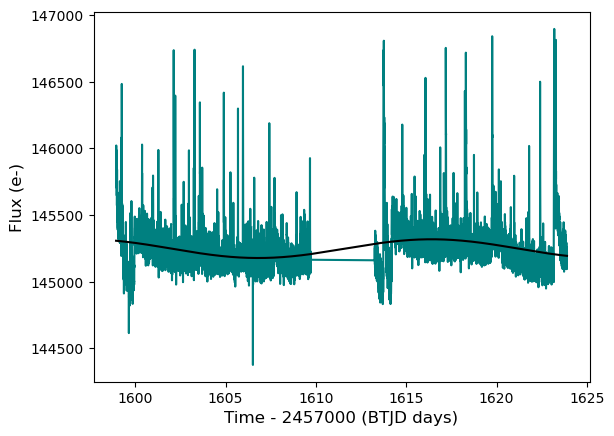

In [497]:
plt.plot(lightcurve.time.value, lightcurve.flux.value, color='teal')
plt.plot(lightcurve.time.value, y_fit, color='black')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

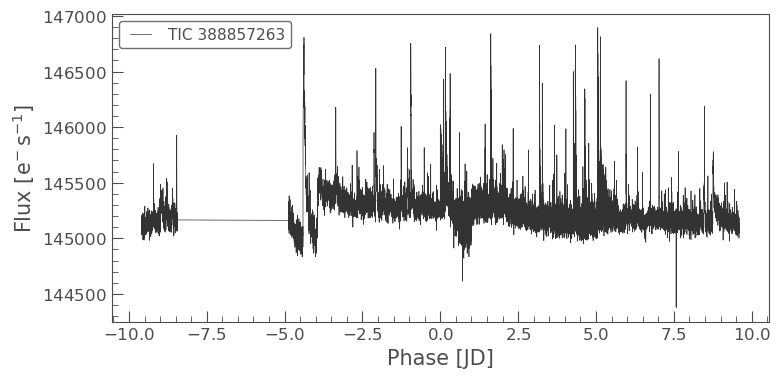

In [498]:
# for fun, we can fold at this period
lightcurve.fold(period=1/best_frequency).plot()

Dividing out this sinusoid yields a less variable dataset.

Text(0, 0.5, 'Flux (e-)')

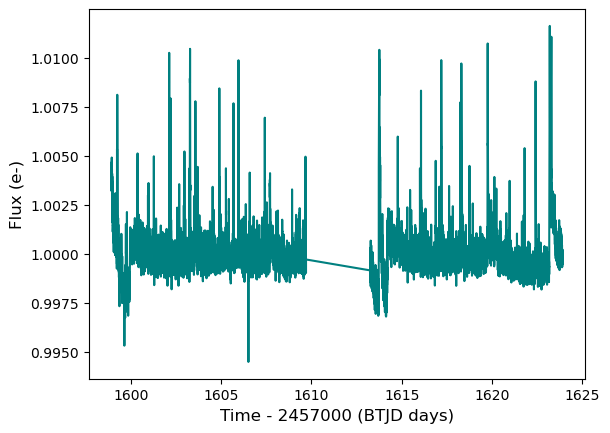

In [499]:
cleaned_once = lightcurve.flux.value/y_fit

plt.plot(lightcurve.time.value, cleaned_once, color='teal')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

There still might be periodicity within the data. Let's repeat the above process to see if we can find any more variability.

In [500]:
ls = LombScargle(lightcurve.time.value, cleaned_once)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

How do we know that we're finding "real" periodicity? One measure is the [False Alarm Probability](https://docs.astropy.org/en/stable/timeseries/lombscargle.html#peak-significance-and-false-alarm-probabilities). This value loosely tells us the significance of a peak in the Lomb-Scargle periodogram. If the false alarm probability is (much less than one), then the chance of this "periodicity" being due to random noise is very low. 

In [501]:
ls.false_alarm_probability(power.max()) 

2.663645822664504e-137

As another check we can check the power output of the Lomb-Scargle periodogram.

Text(0.5, 0, 'Period (days)')

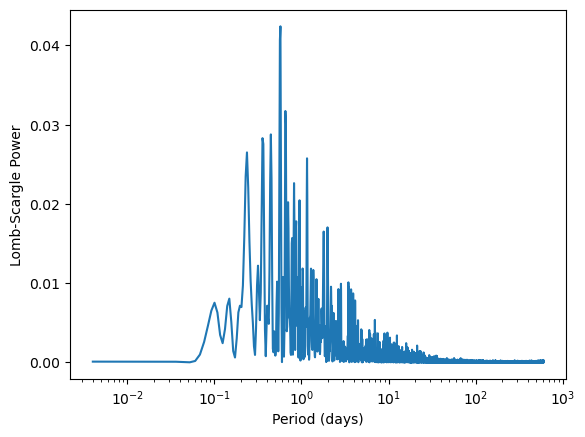

In [502]:
plt.plot(frequency, power)
plt.xscale('log')
plt.ylabel('Lomb-Scargle Power')
plt.xlabel('Period (days)')

Text(0, 0.5, 'Flux (e-)')

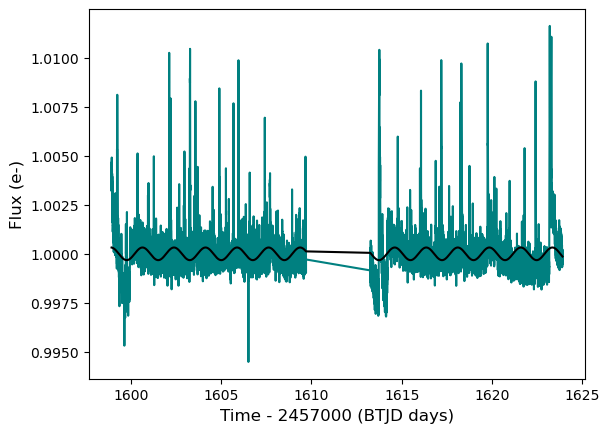

In [503]:
plt.plot(lightcurve.time.value, cleaned_once, color='teal')
plt.plot(lightcurve.time.value, y_fit, color='black')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

In [504]:
cleaned_twice = cleaned_once/y_fit

Text(0, 0.5, 'Flux (e-)')

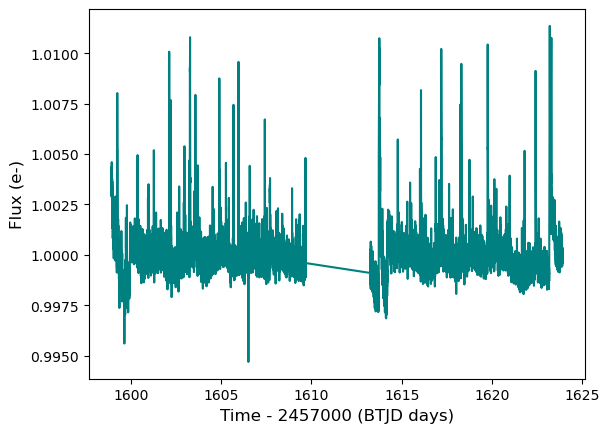

In [505]:
plt.plot(lightcurve.time.value,cleaned_twice, color='teal')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

# Flare candidate detection

To detect flares in our data, we first need to divide by a running mean. This running mean can be computed by convolving our dataset with a 1D box kernel, with the width of the box corresponding to the region over which we'd like to calculate our running mean.

In [506]:
global_mask_length = round((1.4 * u.day / exposure_time).si.value)

In [507]:
global_mask_length

1008

Text(0, 0.5, 'Flux (e-)')

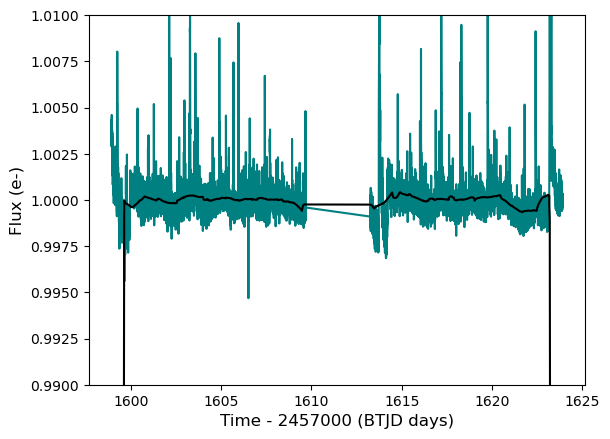

In [508]:
width = global_mask_length # arjun: worth motivating?
mean_kernel = Box1DKernel(width=width)

running_mean = convolve(cleaned_twice, mean_kernel)

plt.plot(lightcurve.time.value, cleaned_twice, color='teal')

dt = np.diff(lightcurve.time.value)[0]

plt.plot(lightcurve.time.value, running_mean, color='black')

# zoom in and inspect a specific region
# plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)

plt.ylim(0.99, 1.01)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

Next, we'd like to flag all those points with flux > 3 standard deviations above the running mean.

Text(0, 0.5, 'Flux (e-)')

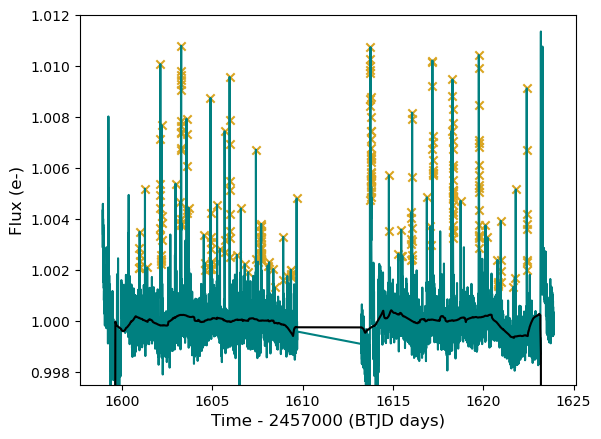

In [524]:
# calculate running standard deviation
sigma_2 = convolve(np.square(cleaned_twice - running_mean), mean_kernel)

sigma =  np.sqrt(sigma_2)


mask = cleaned_twice > running_mean + 2.8 * sigma

plt.scatter(lightcurve.time.value[mask], cleaned_twice[mask], marker='x', color='goldenrod')

plt.plot(lightcurve.time.value, running_mean, color='black', zorder=100)



plt.plot(lightcurve.time.value, cleaned_twice, color='teal')
plt.ylim(0.9975, 1.012)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

Finally, we only consider the marked events to be flares if they last longer than 6 minutes; this threshold was empirically determined by [Günther et al. 2020.](https://iopscience.iop.org/article/10.3847/1538-3881/ab5d3a/meta) to sufficiently mask out noise masquerading as flares.

To mask our data accordingly, we'll need to see how many time steps in our data corresponds to 6 minutes.

In [521]:
flare_length_exp = ((6 * u.minute) / exposure_time).si
flare_length_exp

<Quantity 3.>

In [511]:
# create a ticker to track how many consecutive time stamps are > 3 sigma above running mean
ticker = 0
ticker_arr = []

# only check within the high-flux regions
for m in mask:
    if m:
        ticker += 1
    else:
        ticker = 0
    ticker_arr += [ticker]

In [512]:
flare_detection_mask = np.array(ticker_arr) >= flare_length_exp

Text(0, 0.5, 'Flux (e-)')

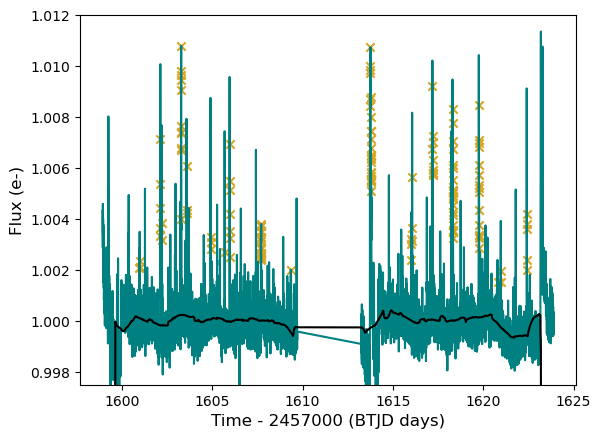

In [523]:
plt.scatter(lightcurve.time.value[flare_detection_mask], cleaned_twice[flare_detection_mask], marker='x', color='goldenrod')


plt.plot(lightcurve.time.value, cleaned_twice,color='teal')

# plt.xlim(1605, 1606)
plt.plot(lightcurve.time.value, running_mean, color='black', )
plt.ylim(0.9975, 1.012)
# plt.xlim(2356, 2357)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

As shown in the plot above, this method will occasionally count long flares as more than one flare. As suggested in the Exercises section, a more detailed pipeline would locate a flare based on the time of its maximum flux. For now, we will treat `flare_detection_mask` as an "in-flare" mask, as opposed to a "mid-time of flare" mask.

## Write timestamps

With our flaring regions detected, we can finally write the timestamps of these events to a file. These data then then be compared to other datasets — e.g., by searching for HST datasets to see if any exposures have been taken near flare events.

In [148]:
formatted_days = lightcurve.time.value[other_mask] + 2457000 # these are in BTJD days

np.save(f'flare_timestamps_{star}.npy', formatted_days)

# Exercises
1. Create a mask to detect the time of maximum flux for a given flare.
2. Try applying the above steps to another star.
3. Add a spline-fit detrending step to the flare-detection pipeline.
4. Perform injection/recovery tests in the flare-detection pipeline.
5. Identify "outburst flares," as described by Günther et al. 2020: "... iterate through all flare events sorted in time. For a given flare, if there is no other candidate peak one hour before or three hours after the event, the outburst is labeled as containing only this single flare. When there are other flares following, the outburst epoch gets expanded accordingly. As a result, outburst epochs span from 1 hr before their earliest flare peak to 3 hr after their latest flare peak."
6. Loop this pipeline over many stars. Try to construct a flare rate vs. stellar rotation period diagram for all known M dwarf exoplanet hosts.
7. Connect this to the HST timestamps for a single M dwarf (e.g., Proxima Centauri) — are there any overlaps?
8. Estimate the energy associated with an individual flare.

# Additional Resources
- [Astropy description of Lomb-Scargle periodograms](https://docs.astropy.org/en/stable/timeseries/lombscargle.html)


# About this Notebook

**Last updated**: 2022-10-02

For support, contact archive@stsci.edu

# Citations
If you use `astropy`, `lightkurve`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citing `astropy`,
`lightkurve`, and `numpy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](https://docs.lightkurve.org/about/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
